# Data Import

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr

# Load the XLSX file into a DataFrame
df = pd.read_excel("ddp_survey.xlsx", sheet_name='travel impacts')
df_add_data = pd.read_excel("ddp_survey.xlsx", sheet_name='additional data')
df = pd.merge(df, df_add_data, on='Response ID', how='inner')
pd.options.display.max_columns = None

# Data Preprocessing
Data preprocessing and data cleaning are important steps in preparing a dataset for use in a machine learning model.

Data cleaning involves identifying and correcting errors, inconsistencies, and missing values in the dataset. This can include correcting typos or formatting errors in the data, identifying and dealing with outliers or missing values, and handling inconsistent or conflicting data. The goal of data cleaning is to ensure that the dataset is accurate, complete, and consistent before it is used for modeling.

Data preprocessing, on the other hand, involves transforming and preparing the dataset so that it can be used effectively by a machine learning model. This can include scaling or normalizing the data, handling categorical data by encoding it into numerical form, and feature engineering, which involves creating new features from the existing data that may be more informative for the model.

Some common data preprocessing techniques include:

Scaling and normalization: This involves rescaling the values of each feature to have a similar range, to prevent any one feature from dominating the others.

Handling categorical data: This involves encoding categorical data into numerical form, such as one-hot encoding or label encoding.

Handling missing values: This can involve imputing missing values with mean or median values, or using more advanced techniques like k-nearest neighbors (KNN) imputation.

Feature engineering: This involves creating new features from the existing data that may be more informative for the model, such as using the date to extract features like month or day of the week.

Data preprocessing and cleaning are important steps in preparing a dataset for use in a machine learning model, as they can have a significant impact on the performance of the model. By ensuring that the data is accurate, complete, and consistent, and by transforming it into a form that is suitable for machine learning, we can build more accurate and effective models.

## Data Cleaning:

In [5]:
# process data
df['Own bike'].fillna('No', inplace=True)
df['Own bike'] = df['Own bike'].replace({"No, I do not own a bicycle that I use for my commute":"No", 
                                        "No, I already owned a bicycle that I used for commuting prior to September 2021":"Yes", 
                                        "Other (please specify)": "No",
                                        "Yes":"Yes"})

df['business provide off-street bike parking spaces'].fillna('No', inplace=True)
df['business provide off-street bike parking spaces'] = df['business provide off-street bike parking spaces'].replace({"Yes": "Yes",
                                                              "No": "No",
                                                              "Other": "No", 
                                                              "I do not know": "No"})



df['remote work policy'].fillna('Must be in the workplace every day', inplace=True)
df['remote work policy'] = df['remote work policy'].replace({"Other: ":"Must be in the workplace every day"})

df['employer provided transportation programs'].fillna('NA', inplace=True)

df['Interstop'].fillna('Never', inplace=True)


df['business name'].replace(0,"(Not Specified)", inplace=True)

df['employer provided transportation programs'] = df['employer provided transportation programs'].apply(lambda x: x.replace("Prizes, drawings or contests for cash or other items for not driving alone", 
                                                                              "Prizes/drawings/contests for cash or other items for not driving alone"))

df['employer provided transportation programs'] = df['employer provided transportation programs'].apply(lambda x: x.replace("donâ€™t", "don't"))


# replace zeros with NaN
list_of_columns = ['annual gross income', 'age group', 'gender', 'race']
df[list_of_columns] = df[list_of_columns].replace(0, np.nan)

# Define the values to replace with NaN
to_replace = ["-", "yes", "na", "n/a", 0, "0", "no", "?", "!"]
list_of_columns = ['home address', 'employer', 'work address', 'employer name', 'home zip code', 'work zip code']
df[list_of_columns] = df[list_of_columns].applymap(lambda x: str(x).lower() if isinstance(x, str) else x).replace(to_replace, np.nan)

# replace zeros with NaN for fractional times
list_of_columns = ['arrival time at work', 'departure time from work']
df[list_of_columns] = df[list_of_columns].replace(0, np.nan)


# when time/distance is NaN, it is a good guess that time/distance is too high that the mode is not accessible 
df['time bike'].fillna(99999, inplace=True)
df['distance bike'].fillna(99999, inplace=True)
df['time drive'].fillna(99999, inplace=True)
df['distance drive'].fillna(99999, inplace=True)
df['time transit'].fillna(99999, inplace=True)
df['distance transit'].fillna(99999, inplace=True)
df['time walk'].fillna(99999, inplace=True)
df['distance walk'].fillna(99999, inplace=True)


# Utility Functions
functions that will be used later on are defined in the following.

In [6]:
df['Monday mode'].value_counts()['Bike or e-bike (non-bikeshare)'] + \
df['Tuesday mode'].value_counts()['Bike or e-bike (non-bikeshare)'] + \
df['Wednesday mode'].value_counts()['Bike or e-bike (non-bikeshare)'] + \
df['Thursday mode'].value_counts()['Bike or e-bike (non-bikeshare)'] + \
df['Friday mode'].value_counts()['Bike or e-bike (non-bikeshare)'] 

990

In [7]:
# a function for parsing daily parking cost
def extract_first_number(x):
    if pd.isna(x):
        return float('nan')
    elif isinstance(x, (int, float)):
        return x
    elif isinstance(x, str):
        pattern = r'\d+(\.\d+)?'
        match = re.search(pattern, x)
        if match:
            number = float(match.group())
            if 'month' in x.lower():
                number /= 20
            return number
    return float('nan')


df['daily parking cost'] = df['daily parking cost'].apply(extract_first_number)
df['daily parking cost'].fillna(0, inplace=True)

In [8]:
# process employer provided transportation programs
def add_new_columns(df, column_name):
    
    df_new = df.copy()
    # Split the string in the specified column by comma delimiter and convert to a set
    all_values = set(",".join(df_new[column_name]).split(","))
    
    # Loop through the set of all unique values and add a new column to the DataFrame for each
    for new_col in all_values:
        # Check if the value is already a column in the DataFrame
        if new_col not in df_new.columns:
            if new_col not in ["Other", "NA"]:
                # If it's not already a column, add it and fill with 'Yes' if it appears in the original column
                df_new[new_col] = df_new[column_name].apply(lambda x: 1 if new_col in x.split(",") else 0)
    
    return df_new

df = add_new_columns(df, 'employer provided transportation programs')
df.rename(columns={"I don't know if any of these are provided": 
                   "Not knowing employer provided transportation benefits"}, inplace=True)



In [9]:
# confirm the format of response IDs
def checkPatternResponseID(string):
    # Define the regular expression pattern
    pattern = r'^R_[a-zA-Z0-9]{15}$'

    # Test the string with the pattern
    is_match = bool(re.match(pattern, string))
    return is_match

responseID_validations = df['Response ID'].apply(checkPatternResponseID)

# Check if any 'Is Response ID' value is False
if any(responseID_validations == False):
    print('Wrong!')

# Remove the rows where 'Is Response ID' is False
df = df[responseID_validations == True]

In [10]:
# match the format of zip codes
def get_first_5_digits(string):
    
    # Check if the input is NaN and return NaN if it is
    if isinstance(string, float) and np.isnan(string):
        return None
    
    # check if the variable is of type str
    if not isinstance(string, str):
        # convert the variable to a string
        string = str(string)
    
    pattern = r'^\d{5}|^\d{5}-\d*'
    match = re.search(pattern, string)
    if match:
        return match.group(0)[:5]
    else:
        return None

list_of_columns = ['home zip code', 'work zip code']    
df[list_of_columns] = df[list_of_columns].applymap(lambda x: get_first_5_digits(x) if get_first_5_digits(x) else np.nan)

In [11]:
# determine the age
def age_range_average(age_range):
    
    # Check if the input is NaN and return NaN if it is
    if isinstance(age_range, float) and np.isnan(age_range):
        return np.nan
    
    # Check if the string is "0" and return 0 if it is
    if age_range == 0:
        return 0
    
    # Use regular expressions to extract the numbers from the string
    match = re.search(r'(\d+)\s*to\s*(\d+)|Under\s*(\d+)|(\d+)\s*or\s*older', age_range)
    if match:
        if match.group(1) and match.group(2):
            # If the pattern matches "X to Y", calculate the average of X and Y
            x = int(match.group(1))
            y = int(match.group(2))
            return (x + y) / 2
        elif match.group(3):
            # If the pattern matches "Under X", calculate the average of 0 and X
            x = int(match.group(3))
            return x - 2
        elif match.group(4):
            # If the pattern matches "X or older", return X as the average
            x = int(match.group(4))
            return x + 2
    else:
        # Return None if no match was found
        return None

# apply the function on the 'A' column and add the result as a new column
df = df.assign(new_col=df['age group'].apply(age_range_average))
# change the name of the column
df = df.rename(columns={'new_col': 'average age group'})

In [12]:
# determine the average salary
def extract_salary_number(salary_string):
    
    # Check if the input is NaN and return NaN if it is
    if isinstance(salary_string, float) and np.isnan(salary_string):
        return np.nan
    
    # check if the variable is of type str
    if not isinstance(salary_string, str):
        # convert the variable to a string
        salary_string = str(salary_string)
    
    # Use regular expressions to extract the salary number
    if salary_string.lower() == "0":
        salary_regex = r"0"
    elif "over" in salary_string.lower():
        salary_regex = r"over \$(\d{1,3}(,\d{3})*)"
    elif "less than" in salary_string.lower():
        salary_regex = r"less than \$(\d{1,3}(,\d{3})*)"
    else:
        salary_regex = r"\$(\d{1,3}(,\d{3})*)( to (\d{1,3}(,\d{3})*))?"
    matches = re.match(salary_regex, salary_string.lower())

    # Extract the salary number from the regular expression match
    if salary_string.lower() == "0":
        salary_number = 0
    elif "over" in salary_string.lower() or "less than" in salary_string.lower():
        salary_number = int(matches.group(1).replace(",", ""))
    else:
        lower_bound = int(matches.group(1).replace(",", ""))
        upper_bound = int(matches.group(4).replace(",", "")) if matches.group(4) else None
        if upper_bound is not None:
            salary_number = (lower_bound + upper_bound) / 2
        else:
            salary_number = lower_bound

    return salary_number

# apply the function on the 'A' column and add the result as a new column
df = df.assign(new_col=df['annual gross income'].apply(extract_salary_number))
# change the name of the column
df = df.rename(columns={'new_col': 'average annual gross income'})

In [13]:
# convert fractional time to time object
def convert_fraction_to_time(fraction):
    # Calculate the number of seconds in the fraction of a day
    total_seconds = round(fraction * 24 * 60 * 60)

    # Create a timedelta object from the total number of seconds
    delta = timedelta(seconds=total_seconds)

    # Create a datetime object representing the start of the day
    start_of_day = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)

    # Add the timedelta to the start of the day to get the final datetime object
    final_time = start_of_day + delta

    return final_time.time()

In [14]:
def modal(percentage):
    modal = "NA"
    if percentage < 0.2:
        modal = "0 day per week"
    elif percentage >= 0.2 and percentage < 0.4 :
        modal = "1 day per week"
    elif percentage >= 0.4 and percentage < 0.6 :
        modal = "2 days per week"
    elif percentage >= 0.6 and percentage < 0.8 :
        modal = "3 days per week"
    elif percentage >= 0.8 and percentage < 1 :
        modal = "4 days per week"
    elif percentage == 1 :
        modal = "5 days per week"
    
    return modal
        

In [15]:
def clean_gender(df):
    df = df.copy()  # make a copy of the DataFrame to avoid modifying the original
    df = df.loc[df['gender'].isin(["Female", "Male"])]  # keep only rows with gender values of 0 or 1
    df = df.reset_index(drop=True)  # reset the index after dropping rows
    return df

In [16]:
# replace Yes to 1, No to 0
def replace_yes_no(df, col_names):
    df_new = df.copy()
    for col in col_names:
        df_new[col] = df_new[col].replace({"Yes": 1, "No": 0})
    return df_new

In [17]:
# group by on a given column name
def group_and_count(df, group_column_name, count_columns):
    grouped = df.groupby(group_column_name)
    result = grouped.size().reset_index(name='counts')
    
    for col in count_columns:
        count_by_group = grouped[col].value_counts().unstack(fill_value=0)
        count_by_group = count_by_group.add_prefix(col+'_').reset_index()
        result = result.merge(count_by_group, on=group_column_name)
    
    result = result.sort_values('counts', ascending=False)
    
    return result

In [18]:
def onehot_encode_columns(df, columns):
    
    df_new = df.copy()

    # Create a new DataFrame to hold the encoded columns
    encoded_df = pd.DataFrame()

    # Create a list to hold the new column names
    new_cols = []

    # Iterate over each column to encode
    for col in columns:
        # Perform one-hot encoding for the column
        encoded_col = pd.get_dummies(df_new[col], prefix=col)

        # Append the encoded column(s) to the new DataFrame
        encoded_df = pd.concat([encoded_df, encoded_col], axis=1)

        # Add the new column names to the list
        new_cols.extend(encoded_col.columns)

    # Merge the encoded columns back into the original DataFrame
    df_new = pd.concat([df_new, encoded_df], axis=1)

    # Drop the original columns from the DataFrame
    df_new = df_new.drop(columns=columns)

    return df_new, new_cols


In [19]:
def plot_correlation(df, target_col, fig_title):
    # calculate correlations of all columns with target column
    correlations = df.corr(method='pearson')[target_col].sort_values(ascending=False)
    
    # remove the target column from the correlations list
    correlations = correlations.drop(target_col)
    
    # create a seaborn barplot with colormaps
    sns.set(style='whitegrid')
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=correlations.values, y=correlations.index, palette='icefire')
    
    plt.title(fig_title)
    plt.xlabel('Correlation')
    plt.ylabel('Features')
    
    # Set the x-axis limits
    ax.set(xlim=(-1, 1))
    
    # Export the plot as a PNG file
    plt.savefig('Correlation_{}.png'.format(fig_title), bbox_inches='tight', dpi=600)
    plt.show()
    
    return correlations


In [20]:
def add_frequency_of_modes(df, mode_type):
    
    # Define the list of column names to search for matches
    columns_to_search = ["Monday mode", "Tuesday mode", "Wednesday mode", "Thursday mode", "Friday mode"]

    # Initialize a list to store the counts
    modal_frequency = []

    # Loop through each row of the DataFrame and count the matches
    for index, row in df.iterrows():
        match_count = 0
        for col_name in columns_to_search:
            if row[col_name] == mode_type:
                match_count += 1
        modal_frequency.append(modal(match_count/len(columns_to_search)))

    # Add the match counts to the DataFrame as a new column
    df[f"frequency of {mode_type}"] = modal_frequency
    
    return df

all_modes = list(df['Monday mode'].unique())
for mode in all_modes:
    df = add_frequency_of_modes(df, mode)

# Post-Processed Data
Let's see what the post processed data look like, and where there are missing values.

In [21]:
# plot = sns.heatmap(df.T.isnull(), xticklabels=False, yticklabels=True, cbar=False, cmap='viridis')
# plot.tick_params(axis='y', labelsize=9)

# # modify the size of the figure
# fig = plt.gcf()
# fig.set_size_inches(10, 20)
# plot.set_title("Highlighting na/NaN/null data values", fontsize=12)
# # add axis titles
# plot.set_xlabel("Respondents", fontsize=12)
# plot.set_ylabel("Features", fontsize=12)

# # show the plot
# plt.show()

# plt.savefig('missing data.png', bbox_inches='tight', dpi=600)


# Correlations
It would be interesting to see which factors are highly correlated with different commute modes.

## Bike:
Let's focus on bike-related features.

In [22]:
def filter_by_threshold(df, column_name, threshold):
    # Group the dataframe by the column name
    grouped = df.groupby(column_name)
    
    # Filter the groups based on the threshold
    filtered_groups = [group for group, data in grouped if len(data) >= threshold]
    
    # Filter the original dataframe based on the filtered groups
    filtered_data = df[df[column_name].isin(filtered_groups)]
    
    return filtered_data

In [23]:
df.to_excel('post processed data.xlsx')
pp_df = filter_by_threshold(df, 'business name', 50)
pp_df.to_excel('post processed data businesses gte 50 employees.xlsx')
df['business provide off-street bike parking spaces'].value_counts()

No     3313
Yes     354
Name: business provide off-street bike parking spaces, dtype: int64

In [24]:
def group_by_and_set_threshold(df, col, portion):
    # Group the dataframe by business name
    grouped = df.groupby('business name')
    for name, group in grouped:
        # Calculate the threshold for this group
        threshold = group[col].value_counts(normalize=True).get(1, 0) >= portion
        
        # Set the values of the column based on the threshold
        df.loc[df['business name'] == name, col] = int(threshold)
    
    return df

df = replace_yes_no(df, list(df.columns))

In [25]:
def categorize_income(x):
    
    if x == 'Less than $24,999':
        return 1
    elif x == '$25,000 to 49,999':
        return 2
    elif x == '$50,000 to 74,999':
        return 3
    elif x == '$75,000 to 99,999':
        return 4
    elif x == '$100,000 to 149,999':
        return 5
    elif x == 'Over $150,000':
        return 6
    else:
        return np.nan
    
df['annual income level'] = df['annual gross income'].apply(categorize_income)

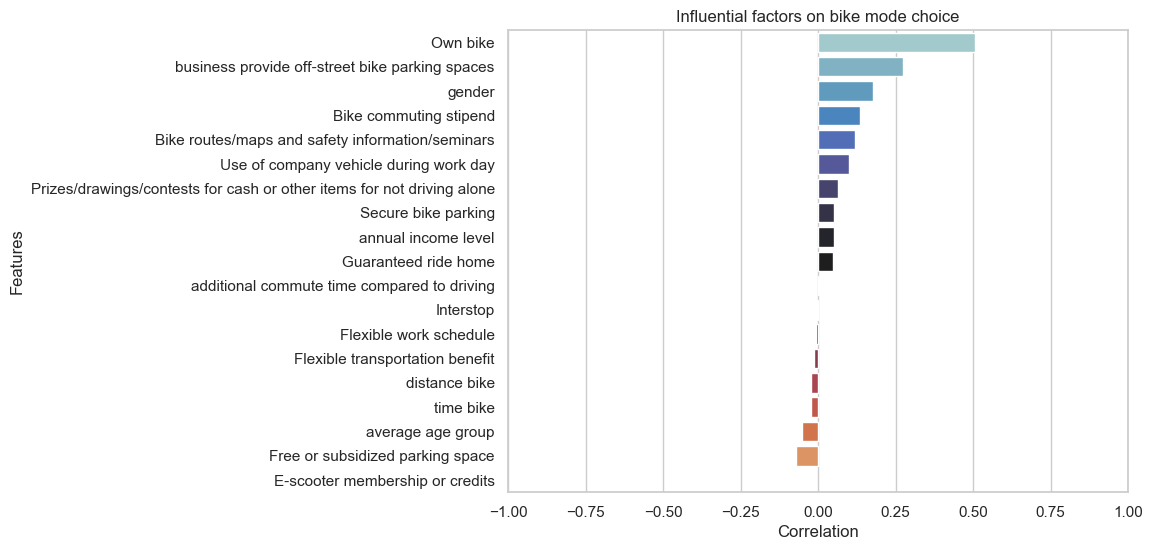

Own bike                                                                  0.507488
business provide off-street bike parking spaces                           0.274945
gender                                                                    0.178708
Bike commuting stipend                                                    0.134244
Bike routes/maps and safety information/seminars                          0.118105
Use of company vehicle during work day                                    0.098818
Prizes/drawings/contests for cash or other items for not driving alone    0.065582
Secure bike parking                                                       0.052622
annual income level                                                       0.050345
Guaranteed ride home                                                      0.048739
Guaranteed ride home                                                      0.048739
additional commute time compared to driving                               0.003798
Inte

In [26]:
bike_related_cols = ['time bike',
                     'average age group',
                     'gender',
                     'annual income level',
                     'distance bike', 
                     'Guaranteed ride home',
                     'Free or subsidized parking space',
                     'Own bike', 
                     'Interstop', 
                     'Years of commuting by bike',
                     'business provide off-street bike parking spaces',
                     'Bike commuting stipend', 
                     'Bike routes/maps and safety information/seminars',
                     'E-scooter membership or credits','Flexible work schedule',
                     'Flexible transportation benefit',
                     'Prizes/drawings/contests for cash or other items for not driving alone',
                     'Secure bike parking','Guaranteed ride home',
                     'Use of company vehicle during work day',
                     'frequency of Bike or e-bike (non-bikeshare)']


df['Years of commuting by bike'].fillna(0, inplace=True)

df_modified = df.copy()
for prg in ['business provide off-street bike parking spaces',
             'Bike commuting stipend', 
             'Bike routes/maps and safety information/seminars',
             'E-scooter membership or credits',
             'Flexible work schedule',
             'Flexible transportation benefit',
             'Prizes/drawings/contests for cash or other items for not driving alone',
             'Secure bike parking',
             'Guaranteed ride home']:
    portion = 0.25
    df_modified = group_by_and_set_threshold(df_modified, prg, portion)

business_size_threshold = 0
df_modified = filter_by_threshold(df_modified, 'business name', business_size_threshold)

df_bike = df_modified[bike_related_cols].copy()




df_bike['Years of commuting by bike'].replace({'1 to 2 years': 2, 
                                         '2 to 4 years': 3,
                                         'Less than 1 year': 1,
                                         'More than 4 years': 4}, inplace=True)
df_bike['Interstop'].replace({'Never':0,
                              'Sometimes': 1,
                              'Most of the time': 3,
                              'Always': 4,
                              'About half the time': 2}, inplace=True)

df_bike['additional commute time compared to driving'] = df['time bike'] - df['time drive']

df_bike = replace_yes_no(df_bike, list(df_bike.columns))



df_bike['frequency of Bike or e-bike (non-bikeshare)'].replace({
    "0 day per week": 0,
    "1 day per week": 1,
    "2 days per week": 2,
    "3 days per week": 3,
    "4 days per week": 4,
    "5 days per week": 5,
    "6 days per week": 6,
    "7 days per week": 7,
}, inplace=True)

df_bike = clean_gender(df_bike)
# df_bike, new_cols = onehot_encode_columns(df_bike, ['gender'])
df_bike.replace({"Female": 0, "Male":1}, inplace=True)

df_bike.drop('Years of commuting by bike', axis=1, inplace=True)

df_bike.dropna(inplace=True)

plot_correlation(df_bike, 'frequency of Bike or e-bike (non-bikeshare)', 'Influential factors on bike mode choice')


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import exp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Split the data into features and target
X = df_resampled.drop(['frequency of Bike or e-bike (non-bikeshare)'], axis=1)  # features
y = df_resampled['frequency of Bike or e-bike (non-bikeshare)']  # target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Create a logistic regression model and fit it to the scaled data
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train_scaled, y_train)

# Predict on the testing set and evaluate the accuracy
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



# Get the coefficients of the features and convert them to odds ratios
coefficients = pd.Series(model.coef_[0], index=X.columns)
odds_ratios = pd.Series(map(lambda x: exp(x), coefficients), index=X.columns)

# Sort the odds ratios in descending order
odds_ratios_sorted = odds_ratios.sort_values(ascending=False)

# Plot the odds ratios on a horizontal bar chart
plt.figure(figsize=(10, 10))
# odds_ratios_sorted.drop('Years of commuting by bike', inplace=True)
sns.barplot(x=odds_ratios_sorted.values, y=odds_ratios_sorted.index)
plt.xscale('log')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.title('Multinomial Logistic Regression Odds Ratios')

# Add data labels to the plot
for i, v in enumerate(odds_ratios_sorted):
    plt.text(v + 0.01, i, str(round(v, 2)))

plt.savefig('Multinomial Logistic Regression Odds Ratios.png', bbox_inches='tight', dpi=800)
plt.show()


NameError: name 'df_resampled' is not defined

In [ ]:
import pandas as pd
from statsmodels.discrete.discrete_model import MNLogit

def multinomial_regression(df, dependent_var):
    # Fit multinomial regression model
    model = MNLogit(df[dependent_var], df.drop(dependent_var, axis=1))
    fitted_model = model.fit()

    # Get coefficients and standard errors
    coef_df = pd.DataFrame(fitted_model.params, columns=['Coefficient'])
    coef_df['Std_Error'] = fitted_model.bse
    coef_df.reset_index(inplace=True)
    coef_df.rename(columns={'index': 'Variable'}, inplace=True)

    # Test statistical significance of coefficients
    p_values = fitted_model.pvalues
    coef_df['P_Value'] = p_values

    # Return dataframe with coefficients and p-values
    return coef_df


In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

# Load data into a pandas DataFrame
data = df_bike.copy()

# Define the target column
target_column = 'frequency of Bike or e-bike (non-bikeshare)'

# Calculate mutual information for each feature
mi_scores = []
for column in data.columns:
    if column != target_column:
        mi_score = mutual_info_regression(data[[column]], data[target_column])[0]
        mi_scores.append((column, mi_score))

# Sort the scores by mutual information value in descending order
mi_scores.sort(key=lambda x: x[1], reverse=True)

# Convert the results to a pandas DataFrame for easy plotting
mi_df = pd.DataFrame(mi_scores, columns=['Feature', 'Mutual Information'])

# Plot the results in a horizontal bar chart
sns.set_style('whitegrid')
sns.set_color_codes('pastel')
sns.barplot(x='Mutual Information', y='Feature', data=mi_df,
            color='b', order=mi_df.sort_values('Mutual Information', ascending=False)['Feature'])

# Add axis labels and a title
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information of Features with Target Column')

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

def compute_correlation(df, target_col):
    # Separate the dataset into features and target columns
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Perform oversampling to balance the dataset
    oversample = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversample.fit_resample(X, y)
    
    # Compute the correlation between features and target
    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    
    correlations = plot_correlation(df_resampled, target_col, 'Influential factors on bike mode choice - oversampling')
    
    return correlations, df_resampled


correlations, df_resampled = compute_correlation(df_bike, 'frequency of Bike or e-bike (non-bikeshare)')

In [ ]:
df_bike

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Load data into a pandas DataFrame
data = df_resampled.copy()

# Define the target column
target_column = 'frequency of Bike or e-bike (non-bikeshare)'

# Calculate mutual information for each feature
mi_scores = []
for column in data.columns:
    if column != target_column:
        mi_score = mutual_info_classif(data[[column]], data[target_column])[0]
        mi_scores.append((column, mi_score))

# Sort the scores by mutual information value in descending order
mi_scores.sort(key=lambda x: x[1], reverse=True)

# Convert the results to a pandas DataFrame for easy plotting
mi_df = pd.DataFrame(mi_scores, columns=['Feature', 'Mutual Information'])

# Plot the results in a horizontal bar chart
sns.set_style('whitegrid')
sns.set_color_codes('pastel')
sns.barplot(x='Mutual Information', y='Feature', data=mi_df,
            color='b', order=mi_df.sort_values('Mutual Information', ascending=False)['Feature'])

# Add axis labels and a title
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information of Features with Target Column')

# Show the plot
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

def select_k_best(df, target_col, k=5):
    # separate features and target
    X = df.drop(columns=target_col)
    y = df[target_col]
    
    # apply SelectKBest
    skb = SelectKBest(score_func=mutual_info_classif, k=k)
    skb.fit(X, y)
    
    # get scores and feature names
    scores = skb.scores_
    feature_names = X.columns
    
    # combine into a dataframe
    results_df = pd.DataFrame({'Feature': feature_names, 'Score': scores})
    
    # sort by score in descending order
    results_df = results_df.sort_values(by='Score', ascending=False).reset_index(drop=True)
    
    # plot bar chart using seaborn
    sns.set_style("whitegrid")
    ax = sns.barplot(x="Score", y="Feature", data=results_df, color="skyblue")
    ax.set_xlabel('Mutual Information Score')
    ax.set_ylabel('Feature')
    ax.set_title(f'Top {k} Features')

select_k_best(df_bike, 'frequency of Bike or e-bike (non-bikeshare)', k=10)


In [ ]:
df_bike['frequency of Bike or e-bike (non-bikeshare)'].value_counts()

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def chi_square(df, target_col, feature_col):
    # Create a crosstab of the target and feature columns
    cross_tab = pd.crosstab(df[target_col], df[feature_col])

    # Perform the chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(cross_tab)

    # Calculate the phi coefficient
    phi = np.sqrt(chi2 / len(df))

    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"P-value: {p:.2f}")
    print(f"Phi coefficient: {phi:.2f}")

    return cross_tab

cross_tab = chi_square(df_bike, 'frequency of Bike or e-bike (non-bikeshare)', 'Free or subsidized parking space')
cross_tab


# Multi Nominal Logistic Regression

In [ ]:
grouped = df_bike.groupby('frequency of Bike or e-bike (non-bikeshare)').size().reset_index(name='counts')
sns.barplot(x='frequency of Bike or e-bike (non-bikeshare)', y='counts', 
            hue=['0 day per week','1 day per week','2 days per week','3  days per week','4 days per week','5 days per week'], 
            data=grouped)
plt.xlabel('frequency of bike mode')
plt.ylabel('number of respondents')
for i in range(len(grouped)):
    plt.text(x=i, y=grouped['counts'][i], s=grouped['counts'][i], ha='center')
plt.show()


## Use of Transit

In [ ]:
transit_related_cols = ['time transit', 
                        'average age group',
                     'gender',
                     'average annual gross income',
                     'Interstop', 
                     'Compressed work week (4 work days per week)',
                     'remote work policy',
                     'Flexible work schedule',
                     'Free transit pass (EcoPass)',
                     'Guaranteed ride home',
                     'Flexible transportation benefit',
                     'Subsidized transit fair or pass (EcoPass)',
                     'Prizes/drawings/contests for cash or other items for not driving alone',
                     'Use of company vehicle during work day',
                     'frequency of Used Transit (bus and/or rail)']

df_modified = df.copy()
# for prg in ['Compressed work week (4 work days per week)',
#                      'remote work policy',
#                      'Flexible work schedule',
#                      'Free transit pass (EcoPass)',
#                      'Guaranteed ride home',
#                      'Flexible transportation benefit',
#                      'Subsidized transit fair or pass (EcoPass)',
#                      'Prizes/drawings/contests for cash or other items for not driving alone',
#                      'Use of company vehicle during work day']:
#     portion = 0.25
#     df_modified = group_by_and_set_threshold(df_modified, prg, portion)

df_modified = filter_by_threshold(df_modified, 'business name', 50)

df_transit = df_modified[transit_related_cols].copy()
df_transit['Interstop'].replace({'Never':0,
                              'Sometimes': 1,
                              'Most of the time': 3,
                              'Always': 4,
                              'About half the time': 2}, inplace=True)
df_transit['remote work policy'].replace({"Can work from home 1-2 days a week": 1, 
                                  "Must be in the workplace every day":0,
                                  "Can work from home 3-4 days a week": 2,
                                 "Totally flexible: can work from home every day": 3}, inplace=True)

df_transit['additional commute time compared to driving'] = df['time transit'] - df['time drive']

df_transit = replace_yes_no(df_transit, list(df_transit.columns))

df_transit = clean_gender(df_transit)
df_transit.replace({"Female": 0, "Male":1}, inplace=True)

df_transit['frequency of Used Transit (bus and/or rail)'].replace({
    "0 day per week": 0,
    "1 day per week": 1,
    "2 days per week": 2,
    "3 days per week": 3,
    "4 days per week": 4,
    "5 days per week": 5,
    "6 days per week": 6,
    "7 days per week": 7,
}, inplace=True)

df_transit.dropna(inplace=True)

plot_correlation(df_transit, 'frequency of Used Transit (bus and/or rail)', 'Influential factors on transit mode choice')


In [ ]:
df_transit

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import exp
from imblearn.over_sampling import RandomOverSampler

# Separate the dataset into features and target columns
X = df_transit.drop('frequency of Used Transit (bus and/or rail)', axis=1)
y = df_transit['frequency of Used Transit (bus and/or rail)']

# Perform oversampling to balance the dataset
oversample = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Compute the correlation between features and target
df_resampled_transit = pd.concat([X_resampled, y_resampled], axis=1)


# Split the data into features and target
X = df_resampled_transit.drop(['frequency of Used Transit (bus and/or rail)'], axis=1)  # features
y = df_resampled_transit['frequency of Used Transit (bus and/or rail)']  # target

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a logistic regression model and fit it to the scaled data
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_scaled, y)

# Get the coefficients of the features and convert them to odds ratios
coefficients = pd.Series(model.coef_[0], index=X.columns)
odds_ratios = pd.Series(map(lambda x: exp(x), coefficients), index=X.columns)

# Sort the odds ratios in descending order
odds_ratios_sorted = odds_ratios.sort_values(ascending=False)

# Plot the odds ratios on a horizontal bar chart
plt.figure(figsize=(10, 10))
sns.barplot(x=odds_ratios_sorted.values, y=odds_ratios_sorted.index)
plt.xscale('log')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.title('Multinomial Logistic Regression Odds Ratios')

# Add data labels to the plot
for i, v in enumerate(odds_ratios_sorted):
    plt.text(v + 0.01, i, str(round(v, 2)))

plt.savefig('Multinomial Logistic Regression Odds Ratios.png', bbox_inches='tight', dpi=800)
plt.show()


In [ ]:
grouped = df_transit.groupby('frequency of Used Transit (bus and/or rail)').size()
grouped.plot(kind='bar')
plt.xlabel('frequency of transit use per week')
plt.ylabel('number of respondents')
plt.show()


## Telecommute

In [ ]:
telecommute_related_cols = [
                     'Compressed work week (4 work days per week)',
                     'remote work policy',
                     'Flexible work schedule',
                     'Flexible transportation benefit',
                     'Prizes/drawings/contests for cash or other items for not driving alone',
                     'frequency of Telecommute (worked from home)']

df_telecommute = df[telecommute_related_cols].copy()
df_telecommute['remote work policy'].replace({"Can work from home 1-2 days a week": 1, 
                                  "Must be in the workplace every day":0,
                                  "Can work from home 3-4 days a week": 2,
                                 "Totally flexible: can work from home every day": 3}, inplace=True)


df_telecommute = replace_yes_no(df_telecommute, list(df_telecommute.columns))

df_telecommute['frequency of Telecommute (worked from home)'].replace({
    "0 day per week": 0,
    "1 day per week": 1,
    "2 days per week": 2,
    "3 days per week": 3,
    "4 days per week": 4,
    "5 days per week": 5,
    "6 days per week": 6,
    "7 days per week": 7,
}, inplace=True)

plot_correlation(df_telecommute, 'frequency of Telecommute (worked from home)','Influential factors on telecommute mode choice')


## Drive Alone

In [ ]:
drive_related_cols = [
                     'time drive',
                     'distance drive',
                     'Interstop',
                     'Free or subsidized parking space',
                     'Not knowing employer provided transportation benefits',
                     'Compressed work week (4 work days per week)',
                     'Subsidized transit fair or pass (EcoPass)',
                     'Free transit pass (EcoPass)',
                     'Guaranteed ride home',
                     'remote work policy',
                     'average annual gross income',
                     'Flexible work schedule',
                     'Flexible transportation benefit',
                     'Prizes/drawings/contests for cash or other items for not driving alone',
                     'frequency of Drove alone']

df_drive = df[drive_related_cols].copy()
df_drive['Interstop'].replace({'Never':0,
                              'Sometimes': 1,
                              'Most of the time': 3,
                              'Always': 4,
                              'About half the time': 2}, inplace=True)
df_drive['remote work policy'].replace({"Can work from home 1-2 days a week": 1, 
                                  "Must be in the workplace every day":0,
                                  "Can work from home 3-4 days a week": 2,
                                  "Totally flexible: can work from home every day": 3}, inplace=True)


df_drive['additional commute time due to switch from drive to transit'] = df['time transit'] - df['time drive']
df_drive['additional commute time due to switch from drive to bike'] = df['time bike'] - df['time drive']
df_drive['additional commute time due to switch from drive to walk'] = df['time walk'] - df['time drive']

df_drive = replace_yes_no(df_drive, list(df_drive.columns))

df_drive['frequency of Drove alone'].replace({
    "0 day per week": 0,
    "1 day per week": 1,
    "2 days per week": 2,
    "3 days per week": 3,
    "4 days per week": 4,
    "5 days per week": 5,
    "6 days per week": 6,
    "7 days per week": 7,
}, inplace=True)

plot_correlation(df_drive, 'frequency of Drove alone', 'Influential factors on drive alone mode choice')

# Modal Share By Businesses
Let's see what is the modal share of different commute options looking at each business separately.

In [ ]:
def sum_columns(df):
    # Create an empty dictionary to store column names and their corresponding sum
    col_sum_dict = {}
    
    # removed cols
    rm_cols = []

    # Loop through each column in the dataframe
    for col in df.columns:
        if col not in rm_cols:
            # Split the column name using the delimiter "_"
            col_parts = col.split("_")
            # Check if the last part of the column name is the same as any other column names
            matching_cols = [c for c in df.columns if c.endswith(col_parts[-1]) and c != col]
            if matching_cols:

                # If there are matching columns, sum the values in all columns and store the result in the dictionary
                col_sum = df[[col] + matching_cols].sum(axis=1)
                
                # Store the sum under a new column name
                col_sum_dict[col_parts[-1]] = col_sum

                # ad to removed columns
                rm_cols = rm_cols + [col] + matching_cols
            else:
                # If there are no matching columns, simply store the column in the dictionary with its original name and values
                col_sum_dict[col] = df[col]

    # Return a new dataframe with the columns and their corresponding sum
    return pd.DataFrame(col_sum_dict)

In [ ]:
import matplotlib.ticker as mtick

def plot_stacked_histogram(df):
    # Select only the numeric columns for the normalization and plotting
    df_numeric = df.select_dtypes(include="number")
    
    if 'counts' in df_numeric.columns:
        df_numeric = df_numeric.drop(axis=1, columns='counts')
    
    # Normalize the data so that each row adds up to 1
    df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)
    
    # Sort the columns based on the sum of their values
    df_norm = df_norm[df_norm.sum().sort_values(ascending=False).index]
    
    # Multiply the data by 100 to convert to percentages
    df_norm *= 100
    
    # Plot the normalized data as a stacked horizontal bar chart
    plot = df_norm.plot(kind='barh', 
                        stacked=True, 
                        colormap='Set3', 
                        figsize=(10, 10))
    
    # Access the legend and modify its properties
    plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Set the x-axis tick format to show percentages
    plot.xaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add text labels with the percentages for each bar
    for i, v in enumerate(df_norm.values):
        total = sum(v)
        cumsum = 0
        for j, x in enumerate(v):
            if x >= 10:
                xpos = cumsum + x / 2
                label = f'{x:.1f}%'
                plot.text(xpos, i, label, ha='center', va='center', color='gray', fontsize=8)
            cumsum += x
    
    plt.xlabel("percentage of mode share")
    plt.title("mode share by businesses with 50 or more repondents from")
    
    # Export the plot as a PNG file
    plt.savefig('modal_share_by_business.png', bbox_inches='tight', dpi=600)
    
    # Display the plot with the legend outside the figure
    plt.show()


In [3]:
# group data by business name
group_by_col = ['business name']
business_gp = group_and_count(df, group_by_col, ['Monday mode',
                       'Tuesday mode', 
                       'Wednesday mode',
                       'Thursday mode', 
                       'Friday mode'])

# number of selected modes for each business
modes_business_gp = sum_columns(business_gp).set_index(group_by_col)
filt = modes_business_gp['counts'] >= 50
modes_lg_business_gp = modes_business_gp[filt]

df_numeric = modes_lg_business_gp.select_dtypes(include="number")

if 'counts' in df_numeric.columns:
    df_numeric = df_numeric.drop(axis=1, columns='counts')

# Normalize the data so that each row adds up to 1
df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)

plot_stacked_histogram(modes_lg_business_gp)

NameError: name 'group_and_count' is not defined

# Machine Learning Models

In [175]:
# let's prepare the dataframe for training a decision tree for the specified features

# specify features
dependent_var = ["frequency of Drove alone"]
independent_vars = ["average age group", "gender", "average annual gross income", 'Interstop',
 'Own bike','business provide off-street bike parking spaces','remote work policy','Free or subsidized parking space',
 'Subsidized transit fair or pass (EcoPass)',
 'Flexible transportation benefit',
 'Carpool or Vanpool program',
 'Compressed work week (4 work days per week)',
 'E-scooter membership or credits',
 'Flexible work schedule',
 'Guaranteed ride home',
 'Secure bike parking',
 'Prizes/drawings/contests for cash or other items for not driving alone',
 'Carshare membership or credits',
 'Preferred parking for carpool',
 'Bike routes/maps and safety information/seminars',
 'Private employer shuttle',
 'Use of company vehicle during work day',
 'Free transit pass (EcoPass)',
 'Bike commuting stipend', 
 'time drive',
 'time transit',
 'time walk',
 'time bike']

df = clean_gender(df)
df = replace_yes_no(df, dependent_var + independent_vars)


# create the dataframe
df_DT = df[dependent_var + independent_vars].copy()
df_DT = df_DT.dropna().reset_index(drop=True)
df_DT, new_cols = onehot_encode_columns(df_DT, ['Interstop', 'remote work policy'])
df_DT.to_excel('Decision Tree Input Data.xlsx')
df_DT

,frequency of Drove alone,average age group,gender,average annual gross income,Own bike,business provide off-street bike parking spaces,Free or subsidized parking space,Subsidized transit fair or pass (EcoPass),Flexible transportation benefit,Carpool or Vanpool program,Compressed work week (4 work days per week),E-scooter membership or credits,Flexible work schedule,Guaranteed ride home,Secure bike parking,Prizes/drawings/contests for cash or other items for not driving alone,Carshare membership or credits,Preferred parking for carpool,Bike routes/maps and safety information/seminars,Private employer shuttle,Use of company vehicle during work day,Free transit pass (EcoPass),Bike commuting stipend,time drive,time transit,time walk,time bike,Interstop_About half the time,Interstop_Always,Interstop_Most of the time,Interstop_Never,Interstop_Sometimes,remote work policy_Can work from home 1-2 days a week,remote work policy_Can work from home 3-4 days a week,remote work policy_Must be in the workplace every day,remote work policy_Totally flexible: can work from home every day
0,2 days per week,52.0,Male,124999.5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,16.825000,23.716667,83.166667,28.450000,0,0,0,1,0,0,1,0,0
1,0 day per week,42.0,Male,87499.5,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,27.891667,57.500000,153.816670,56.000000,0,0,0,1,0,0,1,0,0
2,4 days per week,32.0,Female,62499.5,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,46.475000,134.983330,483.300000,151.800000,0,1,0,0,0,1,0,0,0
3,0 day per week,32.0,Female,62499.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.675000,17.450000,20.883333,11.600000,0,0,0,1,0,0,0,1,0
4,0 day per week,52.0,Female,37499.5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,11.025000,25.350000,36.800000,17.016667,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,0 day per week,27.0,Female,62499.5,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,11.100000,26.116667,39.033333,17.100000,0,0,0,1,0,1,0,0,0
3320,0 day per week,32.0,Female,124999.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,30.741667,36.983333,240.133330,101.583330,0,0,0,1,0,1,0,0,0
3321,0 day per week,57.0,Female,87499.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,24.050000,57.783333,146.383330,42.650000,0,0,0,1,0,0,1,0,0
3322,0 day per week,27.0,Female,87499.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.841667,23.433333,25.950000,7.600000,0,0,0,1,0,1,0,0,0


In [176]:
# transorm categorical data
from sklearn.preprocessing import LabelEncoder

le_frequency_driving = LabelEncoder()
le_gender = LabelEncoder()

df_DT_numeric = df_DT.copy()

df_DT_numeric['frequency of Drove alone'] = le_frequency_driving.fit_transform(df_DT['frequency of Drove alone'])
df_DT_numeric['gender'] = le_gender.fit_transform(df_DT['gender'])

# Separate the target variable from the features
target = df_DT_numeric['frequency of Drove alone'].copy()
features = df_DT_numeric.drop('frequency of Drove alone', axis='columns').copy()

# Model Performance Evaluation
The models should be evaluated in terms of different performance metrics.

In [177]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

def evaluate_model(rfc, X_test, y_test):
    # make predictions on the test data
    predictions = rfc.predict(X_test)

    # calculate and print the accuracy score
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    # calculate and print the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:\n{}".format(cm))

    # calculate and print the precision score
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    print("Precision: {:.2f}%".format(precision * 100))

    # calculate and print the recall score
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    print("Recall: {:.2f}%".format(recall * 100))

    # calculate and print the F1 score
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    print("F1 Score: {:.2f}%".format(f1 * 100))
    
    print(classification_report(y_test, predictions))
    
    return cm


# Hyper Parameter Tuning
Hyperparameter tuning is the process of selecting the optimal hyperparameters for a machine learning model. Hyperparameters are model configuration settings that are not learned during training, but rather are set by the data scientist or machine learning engineer. Examples of hyperparameters include the learning rate for gradient descent, the number of hidden layers in a neural network, or the number of trees in a random forest.

Selecting the optimal values for hyperparameters is a critical step in developing an accurate and robust machine learning model. However, there is no single set of hyperparameters that will work best for all datasets or problems. Instead, the optimal hyperparameters will depend on the specifics of the dataset and the model architecture.

Hyperparameter tuning is typically performed using a search algorithm that explores the hyperparameter space and evaluates the performance of the model at each set of hyperparameters. The most common approach is grid search, where a set of hyperparameters is chosen and the performance of the model is evaluated on the training and validation sets. The search algorithm then moves on to the next set of hyperparameters, and the process is repeated until all combinations of hyperparameters have been evaluated.

Other hyperparameter search algorithms include random search, where hyperparameters are sampled randomly from a predefined range, and Bayesian optimization, where a probabilistic model is used to guide the search based on the results of previous evaluations.

Hyperparameter tuning can be a time-consuming process, particularly for large and complex models. However, it is an important step in developing a high-performing machine learning model.

In [178]:
# Model parameters for Random Forest

hyperParameterTuning = False

if hyperParameterTuning:
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [5, 15, 25],
        'min_samples_split': [5, 10],
        'max_features': [0.1, 0.15, 0.2, "auto", "sqrt", "log2"]
    }
    from sklearn.model_selection import KFold
    X = features.copy()
    y = target.copy()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
    cv = KFold(n_splits=5, shuffle=True)

    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier()

    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_rfc = grid_search.best_estimator_
    best_rfc

# Train, Test, and Validation


In [179]:
from sklearn.model_selection import train_test_split
X = features.copy()
y = target.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33)
y.value_counts()

0    1483
3     476
5     441
2     410
1     345
4     169
Name: frequency of Drove alone, dtype: int64

The count of values for frequency of driving during week is significantly higher for class, 5 (i.e., no driving), which determines that the our input data is imbalanced

# Imbalanced Data
Decision trees can be sensitive to imbalanced or biased data, particularly when the data contains one or more classes with significantly more or fewer samples than the others. When one class is much more prevalent than the others, the decision tree may become biased towards that class, resulting in a tree that is more accurate for that class but less accurate for the other classes.

For example, if you have a dataset with 90% positive examples and 10% negative examples, a decision tree may simply classify every example as positive to achieve a high overall accuracy. This is known as the accuracy paradox, and it can be a significant problem in practice, particularly in applications such as fraud detection or medical diagnosis, where the cost of misclassification can be high.

To address this problem, there are several techniques that can be used to handle imbalanced or biased data when building decision trees, including:

1. Undersampling the majority class to balance the class distribution.
2. Oversampling the minority class to balance the class distribution.
3. Using ensemble methods such as Random Forests, which combine the predictions of multiple decision trees trained on different subsets of the data.
4. Using cost-sensitive learning, which assigns different misclassification costs to different classes to reflect the cost of misclassification in practice.

Overall, it is important to carefully consider the class distribution and the potential for bias when building decision trees, and to use appropriate techniques to handle imbalanced or biased data 

## technique#1: class weighting
Using weights for classes is a technique to deal with imbalanced data in machine learning. Imbalanced data occurs when the number of instances of one class is significantly larger than the number of instances of another class. 

Weighting involves assigning a larger weight to the minority class and a smaller weight to the majority class. This means that during training, the loss function will assign more importance to the minority class, making it easier for the model to learn to distinguish between the two classes.

The weight assigned to each class can be determined based on the ratio of the number of instances of that class to the total number of instances. For example, if the minority class represents 10% of the data, it can be assigned a weight of 0.1, while the majority class can be assigned a weight of 0.9.

Using class weights can help to improve the performance of a machine learning model on imbalanced data, especially when combined with other techniques such as resampling, data augmentation, and ensemble methods.

In [180]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights

array([0.37758562, 1.59985632, 1.32559524, 1.14557613, 3.25584795,
       1.26247166])

# Model: Random Forest
Random Forest is a machine learning algorithm that is used for both classification and regression tasks. It is an ensemble learning method that combines multiple decision trees to make more accurate predictions.

Random Forest works by building a large number of decision trees, each of which is trained on a random subset of the training data and a random subset of the features. The trees are built independently and in parallel, without any knowledge of the other trees.

During prediction, the random forest algorithm aggregates the predictions of all the individual trees to produce a final prediction. This is done either by taking a majority vote (in the case of classification) or by averaging the predictions (in the case of regression).

The advantage of using a random forest is that it is less prone to overfitting than a single decision tree. By building many trees on randomly selected subsets of the data, the random forest algorithm reduces the variance of the model and improves its ability to generalize to new, unseen data.

Random Forests are widely used in many real-world applications, such as predicting customer churn, identifying credit risk, detecting fraud, and analyzing medical data. They are known for their accuracy, scalability, and ease of use, and are particularly well-suited for high-dimensional data with complex interactions between features.

In [181]:
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib as mpl


## instantiate a Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, 
                             max_depth=40, 
                             min_samples_split=5, 
                             criterion='gini', 
                             max_features='auto', 
                             class_weight={i: w for i, w in enumerate(class_weights)})

# train the model on the training data
rfc.fit(X_train, y_train)
conf_matrix = evaluate_model(rfc, X_test, y_test)

Accuracy: 57.61%
Confusion Matrix:
[[438   4  11  21   0  26]
 [ 50  14  26  10   1  12]
 [ 41  10  51  13   5  10]
 [ 40   7  13  63   5  24]
 [ 10   3   2  26   1  13]
 [ 29   2  14  31   6  65]]
Precision: 53.01%
Recall: 57.61%
F1 Score: 54.34%
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       500
           1       0.35      0.12      0.18       113
           2       0.44      0.39      0.41       130
           3       0.38      0.41      0.40       152
           4       0.06      0.02      0.03        55
           5       0.43      0.44      0.44       147

    accuracy                           0.58      1097
   macro avg       0.40      0.38      0.38      1097
weighted avg       0.53      0.58      0.54      1097



## technique#2: using Over Sampling Technique
Oversampling is a technique used in machine learning to deal with imbalanced datasets, where the number of instances in one class is significantly lower than the other class. In oversampling, the minority class is artificially increased in size by adding more instances to it, to balance the distribution of classes in the dataset.

There are different ways to perform oversampling, such as:

Random oversampling: This involves randomly duplicating instances from the minority class to increase its size. This can be done until the minority class has the same number of instances as the majority class.

Synthetic Minority Oversampling Technique (SMOTE): This involves creating synthetic instances of the minority class by interpolating between the existing instances. In SMOTE, a new instance is created by selecting two or more instances from the minority class and interpolating between them.

Adaptive Synthetic Sampling (ADASYN): This technique is similar to SMOTE, but it generates more synthetic instances for the minority class that are harder to classify, while generating fewer synthetic instances for the minority class that are easier to classify. This makes the classifier more robust and accurate.

Oversampling can be a useful technique to improve the performance of machine learning models on imbalanced datasets. However, it is important to use oversampling in combination with other techniques such as undersampling, class weighting, and cross-validation to avoid overfitting and achieve better generalization performance.

In [182]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X, y = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33)
y_train.value_counts()

3    1037
0     997
1     987
5     985
4     983
2     972
Name: frequency of Drove alone, dtype: int64

In [183]:
from sklearn.ensemble import RandomForestClassifier

# # instantiate a Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, 
                             max_depth=40, 
                             min_samples_split=4, 
                             criterion='gini', 
                             max_features='auto')

# train the model on the training data
rfc.fit(X_train, y_train)
conf_matrix = evaluate_model(rfc, X_test, y_test)


Accuracy: 92.61%
Confusion Matrix:
[[403  18  12  30   4  19]
 [  7 483   4   0   0   2]
 [ 11   6 470  12   3   9]
 [ 17   5  16 396   2  10]
 [  0   0   0   0 500   0]
 [  8   4   2  15   1 468]]
Precision: 92.57%
Recall: 92.61%
F1 Score: 92.55%
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       486
           1       0.94      0.97      0.95       496
           2       0.93      0.92      0.93       511
           3       0.87      0.89      0.88       446
           4       0.98      1.00      0.99       500
           5       0.92      0.94      0.93       498

    accuracy                           0.93      2937
   macro avg       0.92      0.93      0.92      2937
weighted avg       0.93      0.93      0.93      2937



# Confusion Matrix
confusion matrix is a way to show how the model correctly labels the unseen data

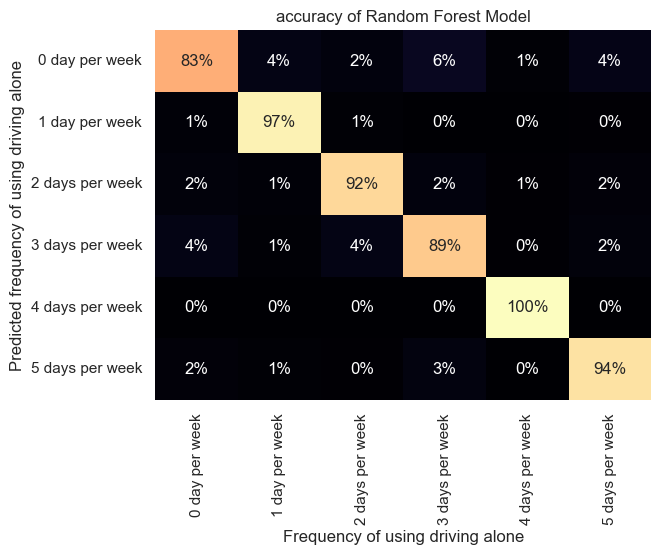

<Figure size 640x480 with 0 Axes>

In [184]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

# Compute the row-wise and column-wise sum of the confusion matrix
row_sum = np.sum(conf_matrix, axis=1)
col_sum = np.sum(conf_matrix, axis=0)

# Compute the normalized confusion matrix
norm_matrix = conf_matrix / row_sum[:, np.newaxis]
sns.heatmap(norm_matrix, 
            annot=True, 
            cmap='magma', 
            fmt='.2f', 
            square=False, 
            cbar=False, 
            xticklabels=le_frequency_driving.classes_, 
            yticklabels=le_frequency_driving.classes_)

# Set the x-axis and y-axis titles
plt.title('accuracy of Random Forest Model')
plt.xlabel('Frequency of using driving alone')
plt.ylabel('Predicted frequency of using driving alone')

# Define a custom formatting function to display values as percentages
def fmt_percent(x):
    return '{:.0%}'.format(x)


# Format the annotations as percentages
ax = plt.gca()
for t in ax.texts:
    t.set_text(fmt_percent(float(t.get_text())))

# Show the plot
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('confusionMatrix (Random Forest).png', dpi=800, bbox_inches='tight')

In [185]:
%matplotlib inline
import os

# Export the first decision tree in the Random Forest as a Graphviz file
export_graphviz(rfc.estimators_[-1], out_file='randomForest.dot', feature_names=X.columns,
                class_names=le_frequency_driving.classes_, filled=True)

# Convert the Graphviz file to a PNG file
os.system('dot -Tpng randomForest.dot -o randomForest.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.354836 to fit


0

# Transportation Program Impacts Predictions:

Let's see how implementing a new transportation program affects the modal share of driving

In [186]:
def activate_program_to_reduce_driving(rfc, df, dependent_var, independent_vars, business_name, activate_programs):
    
    business_df = df.loc[df['business name'] == business_name,:]
    business_df = clean_gender(business_df)
    business_df = replace_yes_no(business_df, dependent_var + independent_vars)
    business_df = business_df.loc[:,dependent_var + independent_vars]
    business_df.dropna(inplace=True)

    business_df_changed = business_df.copy()
    business_df_changed[activate_programs]=1
    
    # transorm categorical data
    from sklearn.preprocessing import LabelEncoder

    le_frequency_driving = LabelEncoder()
    le_gender = LabelEncoder()

    business_df_changed_numeric = business_df_changed.copy()

    business_df_changed_numeric['frequency of Drove alone'] = le_frequency_driving.fit_transform(business_df_changed['frequency of Drove alone'])
    business_df_changed_numeric['gender'] = le_gender.fit_transform(business_df_changed['gender'])

    # Separate the target variable from the features
    target = business_df_changed_numeric['frequency of Drove alone'].copy()
    features = business_df_changed_numeric.drop('frequency of Drove alone', axis='columns').copy()
    
    business_df['frequency of Drove alone'] = business_df['frequency of Drove alone'].apply(lambda x: x.replace("day per week", "").replace("days per week", ""))
    current_frequency_driving = business_df['frequency of Drove alone'].astype('int').sum()
    
    predictions = rfc.predict(features)
    predicted_frequency_driving = predictions.sum()
    
    
    return current_frequency_driving, predicted_frequency_driving
    

In [187]:
filt = df.groupby('business name').aggregate('count')['Response ID'] >= 50
business_gte_50 = df.groupby('business name').aggregate('count').loc[filt].sort_values('Response ID', ascending=False)

business_gte_50.reset_index(inplace=True)
list_businesses_gte_50 = list(business_gte_50['business name'])

activate_programs = ['business provide off-street bike parking spaces','Secure bike parking']
driving_frequency = dict()

df_n, new_cols = onehot_encode_columns(df, ['Interstop', 'remote work policy'])
input_feaures = [x for x in independent_vars if x not in ['Interstop', 'remote work policy']]
input_feaures = input_feaures + new_cols
for business_name in list_businesses_gte_50:  

    current_frequency_driving, predicted_frequency_driving = activate_program_to_reduce_driving(rfc, df_n, dependent_var, input_feaures, business_name, activate_programs)
    driving_frequency[business_name] = {'existing:': current_frequency_driving,
                                        'predicted:':predicted_frequency_driving}
driving_frequency


{'City and County of Denver': {'existing:': 912, 'predicted:': 562},
 'TIAA': {'existing:': 480, 'predicted:': 334},
 'Gates Corporation': {'existing:': 293, 'predicted:': 200},
 'Inspirato': {'existing:': 127, 'predicted:': 66},
 'Other': {'existing:': 277, 'predicted:': 193},
 'IMA Financial Group, Inc.': {'existing:': 249, 'predicted:': 163},
 'Johns Manville Corporation': {'existing:': 345, 'predicted:': 262},
 'VF Corporation': {'existing:': 164, 'predicted:': 118},
 'CBRE': {'existing:': 295, 'predicted:': 197},
 'University of Colorado Denver': {'existing:': 106, 'predicted:': 74},
 'Amazon': {'existing:': 64, 'predicted:': 65},
 'Ardent Mills': {'existing:': 100, 'predicted:': 71},
 'DaVita, Inc.': {'existing:': 63, 'predicted:': 43},
 'Colorado Department of Labor & Employment': {'existing:': 41,
  'predicted:': 21},
 'KPMG': {'existing:': 50, 'predicted:': 24}}

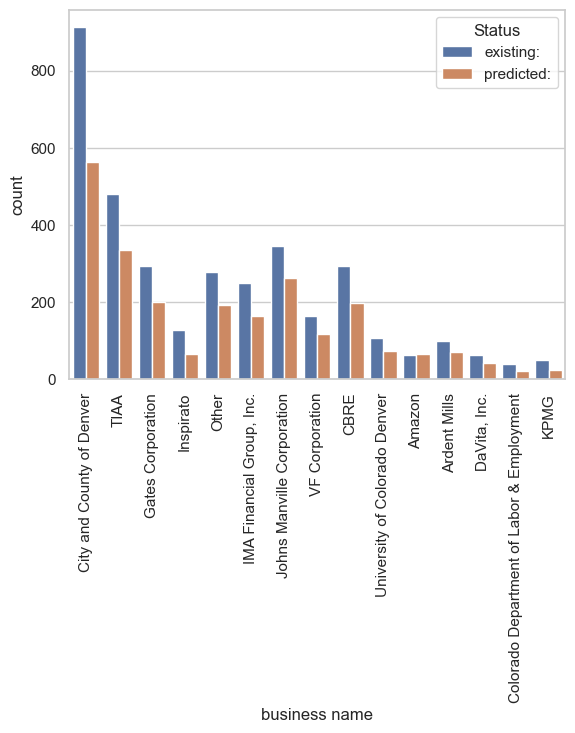

In [188]:
# Convert the dictionary to a Pandas DataFrame
prd_df = pd.DataFrame(driving_frequency).T

# Reset the index and rename columns
prd_df = prd_df.reset_index().rename(columns={'index': 'business name'})

# Melt the DataFrame and rename columns
df_melted = prd_df.melt(id_vars=['business name'], value_vars=['existing:', 'predicted:'], var_name='status', value_name='count').rename(columns={'existing:': 'existing', 'predicted:': 'predicted'})

# Create a Seaborn bar chart
sns.barplot(x='business name', y='count', hue='status', data=df_melted)

# Set the legend title
plt.legend(title='Status')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()



<AxesSubplot: xlabel='Company', ylabel='value'>

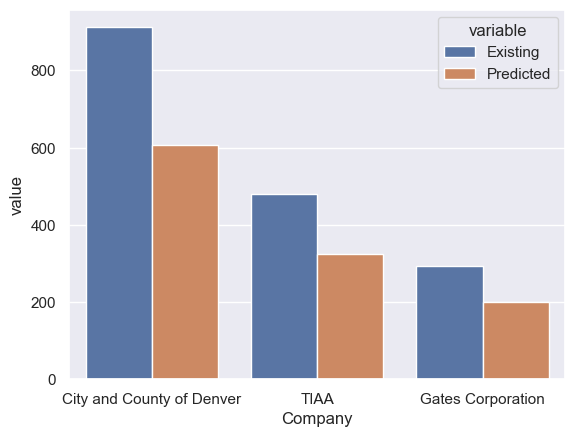

In [189]:
import pandas as pd
import seaborn as sns

# Define the dictionary
data = {'City and County of Denver': {'existing:': 912, 'predicted:': 607},
        'TIAA': {'existing:': 480, 'predicted:': 324},
        'Gates Corporation': {'existing:': 293, 'predicted:': 199}}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict(data, orient='index')
df.columns = ['Existing', 'Predicted']

# Reset the index to make the companies a column
df = df.reset_index()
df = df.rename(columns={'index': 'Company'})

# Create the bar chart using Seaborn
sns.set_style('darkgrid')
sns.barplot(x='Company', y='value', hue='variable', 
            data=pd.melt(df, id_vars='Company', var_name='variable', value_name='value'))


IndexError: index 3 is out of bounds for axis 0 with size 3

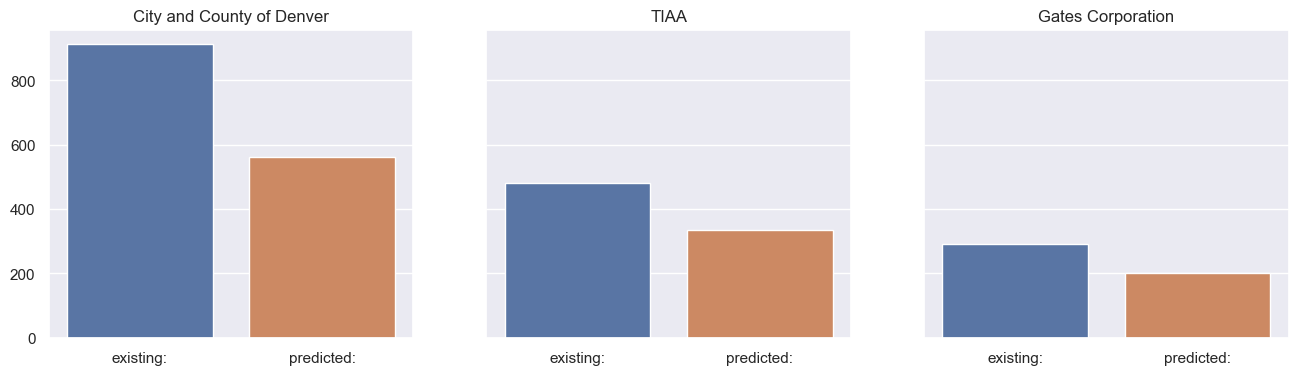

In [190]:
# Create a single figure
fig, axs = plt.subplots(ncols=len(data), figsize=(16, 4), sharey=True)

# Plot each barplot on a separate subplot
for i, (name, values) in enumerate(driving_frequency.items()):
    ax = axs[i]
    sns.barplot(x=list(values.keys()), y=list(values.values()), ax=ax)
    ax.set_title(name)

# Set the y-axis label for the first subplot
axs[0].set_ylabel('Count')

# Show the plot
plt.show()

# Model: Decision Tree
A decision tree is a machine learning algorithm that is used for both classification and regression tasks. It is a type of supervised learning algorithm that is simple to understand and interpret.

A decision tree works by recursively partitioning the feature space into smaller and smaller subsets, based on the values of the input features, until a stopping criterion is met. This results in a tree-like structure, where each internal node represents a decision based on a particular feature, and each leaf node represents a class label (in the case of classification) or a numerical value (in the case of regression).

The decision tree algorithm is trained using a labeled dataset, where each instance is associated with a class label or a numerical value. The algorithm selects the feature that provides the most information gain or reduction in impurity at each node of the tree, and then recursively partitions the data based on the selected feature.

The advantage of using a decision tree is that it is simple to understand and interpret. Decision trees can also handle both categorical and numerical features, and can be used for feature selection and data preprocessing.

However, decision trees can be prone to overfitting if they are too complex and are not regularized. To address this issue, ensemble methods such as Random Forest and Boosting are often used, which combine multiple decision trees to improve their performance and reduce overfitting.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTm = DecisionTreeClassifier(criterion='gini', 
                               max_depth=120, 
                               min_samples_split=10, 
                               max_features='auto')
DTm = DTm.fit(X_train, y_train)

conf_matrix = evaluate_model(DTm, X_test, y_test)

# Plot Decision Tree

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# export the decision tree as a Graphviz format
dot_data = export_graphviz(DTm, out_file=None,
                           feature_names=X.columns,
                           class_names=le_frequency_driving.classes_,
                           filled=True, rounded=True,
                           special_characters=True)


# convert the Graphviz format to a PNG image
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.renderer = "cairo"
graph.render("decisionTree", view=True)

In [ ]:
importance = DTm.feature_importances_

importance = dict(zip(X_train.columns,importance*100))
importance = pd.DataFrame(sorted(importance.items(), key=lambda x:x[1]), columns=['variable', 'importance'])

importance.set_index('variable', inplace=True)

barplot = sns.barplot(importance.T)

plt.xticks(rotation=90)
plt.xlabel('Factors')
plt.ylabel('Percentage of importance (%)')
plt.rcParams.update({'font.size': 8})
fig1 = plt.gcf()
plt.figure(figsize=(20,10))
plt.show()
plt.draw()
fig1.savefig('importanceFactors.png', dpi=500, bbox_inches='tight')

### Confusion Matrix:

In [ ]:
import matplotlib.pyplot as plt

# Compute the row-wise and column-wise sum of the confusion matrix
row_sum = np.sum(conf_matrix, axis=1)
col_sum = np.sum(conf_matrix, axis=0)

# Compute the normalized confusion matrix
norm_matrix = conf_matrix / row_sum[:, np.newaxis]
sns.heatmap(norm_matrix, annot=True, cmap='magma', fmt='.2f', square=False, cbar=False, xticklabels=le_frequency_driving.classes_, yticklabels=le_frequency_driving.classes_)

# Set the x-axis and y-axis titles
plt.title('accuracy of Decision Tree Model')
plt.xlabel('Frequency of using driving alone')
plt.ylabel('Predicted frequency of using driving alone')

# Define a custom formatting function to display values as percentages
def fmt_percent(x):
    return '{:.0%}'.format(x)

# Format the annotations as percentages
ax = plt.gca()
for t in ax.texts:
    t.set_text(fmt_percent(float(t.get_text())))

# Show the plot
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('confusionMatrix.png', dpi=500, bbox_inches='tight')


# Multinominal Logistic Regression
Logistic regression is a type of regression analysis used to model the relationship between a binary dependent variable and one or more independent variables. In Python, logistic regression models can be created using various types of data, including:

Numerical data: This includes data that can be represented as numbers, such as age, income, and temperature.

Categorical data: This includes data that has a limited number of categories, such as gender, race, and education level.

Dummy-coded data: This is a type of categorical data where the categories are represented by binary (0/1) variables, such as whether a person owns a car (0/1) or not.

Ordinal data: This is a type of categorical data where the categories have a natural order, such as education level (high school, college, graduate school).

Text data: This includes data in the form of text, such as product reviews, customer feedback, or social media posts, that can be converted to numerical features using techniques like bag-of-words or TF-IDF.

It's important to note that logistic regression assumes that the independent variables are linearly related to the log odds of the dependent variable, so some data preprocessing, such as feature scaling, may be necessary to meet this assumption.

## Verifying the independecy of variables
In a multinomial logistic regression model, it is important to ensure that the independent variables are not highly correlated with each other, as this can lead to multicollinearity and affect the accuracy and stability of the model.

To verify the independence of variables in multinomial logistic regression, you can use several methods:

Correlation matrix: Compute the correlation matrix of the independent variables using the corr() method of a pandas DataFrame or numpy array. A high correlation coefficient (i.e., close to 1 or -1) between two independent variables indicates that they are highly correlated, and one of them may be redundant in the model.

Variance Inflation Factor (VIF): The VIF is a measure of the degree of multicollinearity between the independent variables in a regression model. It is calculated for each independent variable as 1 / (1 - R^2), where R^2 is the coefficient of determination of a regression model that regresses that variable on all the other independent variables. A high VIF value (i.e., greater than 5 or 10) indicates that the variable is highly correlated with other variables and may need to be removed from the model.

Principal Component Analysis (PCA): PCA is a dimensionality reduction technique that can be used to transform the independent variables into a smaller set of uncorrelated components that capture most of the variance in the data. This can help to identify which variables are most important in explaining the variation in the data, and which variables are redundant or highly correlated.

Domain knowledge: Finally, it is important to use domain knowledge or subject matter expertise to determine which independent variables are most relevant to the outcome variable and which variables can be safely removed from the model without affecting its performance.

By using one or more of these methods, you can verify the independence of the independent variables in a multinomial logistic regression model and ensure that the model is accurate and stable.

### Correlation matrix:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

# Compute the correlation matrix of the independent variables
corr_matrix = X.corr()

# Create heatmap
heatmap = sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', xticklabels=X.columns, yticklabels=X.columns)

# Set font size of xticklabels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)

# Add axis labels and title
plt.xlabel('Variables',fontsize=8)
plt.ylabel('Variables',fontsize=8)
plt.title('Correlation Matrix')

# Show plot
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('correlationMatrix (Logistic Regression).png', dpi=500, bbox_inches='tight')

### Principal Component Analysis (PCA):
Perform principal component analysis (PCA) on the independent variables

In [ ]:

# First, standardize the independent variables
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

# Perform PCA on the standardized independent variables
pca = PCA()
pca.fit(X_std)
pc_names = ['PC' + str(i+1) for i in range(len(X.columns))]
pc_scores = pd.DataFrame(pca.transform(X_std), columns=pc_names)
pc_loadings = pd.DataFrame(pca.components_.T, columns=pc_names, index=X.columns)

# Get explained variance ratios
variance_ratios = pca.explained_variance_ratio_
# Create bar plot
plt.bar(range(len(variance_ratios)), variance_ratios*100)
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')

# Show plot
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('PCA (Logistic Regression).png', dpi=500, bbox_inches='tight')


# Standardization
Standardization is a data preprocessing technique used to scale and transform data to a standard normal distribution with a mean of 0 and a standard deviation of 1. There are several standardization techniques that can be used, including:

StandardScaler: This technique scales the data to have a mean of 0 and a standard deviation of 1. It is the most commonly used standardization technique and is included in many Python libraries, such as scikit-learn.

Min-Max scaling: This technique scales the data to a range between 0 and 1. It can be useful for algorithms that require data to be in a certain range, such as neural networks.

RobustScaler: This technique scales the data using the median and interquartile range instead of the mean and standard deviation. It is more robust to outliers than StandardScaler.

Log transformation: This technique applies a natural logarithm to the data to make it more normally distributed. It is useful for data that is highly skewed.

Box-Cox transformation: This technique transforms the data using a power transformation that maximizes the normality of the distribution. It is useful for data that is highly skewed or has a non-constant variance.

Yeo-Johnson transformation: This is a modified version of the Box-Cox transformation that can be applied to both positive and negative data.

The choice of standardization technique depends on the specific characteristics of the data and the requirements of the algorithm being used. It is important to choose a technique that is appropriate for the data and does not introduce any biases into the analysis.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Perform feature scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build Model:

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train the logistic regression model
LRm = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, C=0.25, penalty='l2')
LRm.fit(X_train_scaled, y_train)

# Evaluate the performance of the model on the test set
y_pred = LRm.predict(X_test_scaled)
conf_matrix = evaluate_model(LRm, X_test_scaled, y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Perform feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
LRm = LogisticRegression(multi_class='multinomial', solver='lbfgs')
LRm.fit(X_train_scaled, y_train)

# Evaluate the performance of the model on the test set
y_pred = LRm.predict(X_test_scaled)
conf_matrix = evaluate_model(LRm, X_test_scaled, y_test)